# Set-up

## Imports

In [91]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm
from NMF_iter import normalize_curves, functional_norm, initialize_W
from PenNMF_iter import initialize_C_gaussian_prior
from scipy.linalg import block_diag
from sklearn.decomposition import NMF

# HOTFIX Parse IMCEI
import locale
locale.setlocale(locale.LC_ALL, 'it_IT')

%load_ext autoreload
%autoreload 1

%aimport PenNMF
%aimport utils
from utils import plot_components, month_to_season
from PenNMF import PenNMF, _loss_nmf, _loss_constraint

import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
sns.set_theme()
pd.options.mode.chained_assignment = None

## Parameters

In [93]:
specific = '_Italy'
train_years = ['2021']
test_years = ['2022', '2023']

## Functions

# Create data matrix $X$

In [94]:
infile = f'data/2_processed/daily_curves{specific}.csv'
# infile = 'data/2_processed/daily_curves_Italy_smoothed_15min.csv'
input_df = pd.read_csv(infile, index_col=0)
# Convert everything in GWh
input_df = input_df / 1000
print(len(input_df))
input_df.head(3)

2191


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Italy_2018-01-01_Holiday,24.743000,23.797000,22.175999,21.042000,20.146999,20.079000,20.942001,21.712000,21.969999,22.967000,...,26.643000,26.807000,29.947001,31.103000,31.537000,30.804001,29.621000,27.749000,25.388000,22.714001
Italy_2018-01-02_Working day,22.714001,20.794001,19.802002,19.573002,19.679000,20.891000,24.197999,28.537000,32.988000,37.794999,...,36.511999,37.393000,41.395000,42.362001,42.081001,39.555000,37.163000,33.313000,29.811000,26.314001
Italy_2018-01-03_Working day,26.314001,24.248999,22.927999,22.537999,22.314001,23.529001,27.206000,32.970999,37.419000,40.908999,...,40.106999,40.662001,44.557000,44.708000,43.818999,41.347000,38.572999,34.229001,30.436999,27.199000


In [95]:
unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
# Drop years for which we don't have indicators
df = df[df.year.astype(int) > 2019]
df_train = df[df.year.isin(train_years)]
df_test = df[df.year.isin(test_years)]
print(len(df))
df.head(3)

1461


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,region,year,month,daytype
Italy_2020-01-01_Holiday,24.300000,23.308000,22.157999,20.786000,19.891000,19.947001,20.578999,21.473999,21.413001,22.792,...,30.459000,30.347000,29.180,27.406000,24.879000,22.212999,Italy,2020,01,Holiday
Italy_2020-01-02_Working day,22.212999,20.395000,19.276000,19.059001,19.167999,20.177000,23.560000,28.026999,31.600000,35.583,...,40.117000,38.273000,35.756,32.371000,28.863001,25.324000,Italy,2020,01,Working day
Italy_2020-01-03_Working day,25.324000,23.275001,21.741000,21.228999,21.438000,22.064999,25.270000,30.257000,34.130000,37.619,...,40.668001,38.369999,35.184,31.951999,28.347001,25.134999,Italy,2020,01,Working day


In [96]:
X_train = df_train.drop(unit_info.columns, axis=1)
X_test = df_test.drop(unit_info.columns, axis=1)
X_train = normalize_curves(X_train)
X_test = normalize_curves(X_test)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Italy_2021-01-01_Holiday,0.040804,0.038742,0.035854,0.033708,0.032238,0.032600,0.034120,0.035383,0.035496,0.038184,...,0.042573,0.043251,0.047590,0.048918,0.050168,0.050272,0.048012,0.045464,0.041705,0.038179
Italy_2021-01-02_Saturday,0.034414,0.031907,0.030306,0.029319,0.029488,0.030321,0.033353,0.036153,0.038945,0.042298,...,0.044727,0.045919,0.050289,0.052199,0.053566,0.051826,0.048080,0.044351,0.039698,0.035197
Italy_2021-01-03_Holiday,0.037353,0.034144,0.032665,0.031295,0.030793,0.031833,0.033681,0.035499,0.037216,0.040036,...,0.043765,0.044670,0.049144,0.051261,0.052497,0.052119,0.048489,0.045250,0.041502,0.037208
Italy_2021-01-04_Monday,0.029707,0.027360,0.026213,0.026345,0.026738,0.027907,0.031743,0.037142,0.042662,0.047633,...,0.049228,0.049020,0.052170,0.052683,0.052748,0.049429,0.045780,0.041584,0.037839,0.033934
Italy_2021-01-05_Working day,0.032900,0.030340,0.028683,0.028162,0.028115,0.029145,0.032760,0.038128,0.043562,0.047061,...,0.048094,0.048353,0.051152,0.051067,0.050467,0.048227,0.044795,0.041040,0.036631,0.032362


In [97]:
X_test.to_pickle('data/2_processed/PenNMF/X_{}.pkl'.format('_'.join(test_years)))

In [98]:
cons_df = pd.read_excel('data/1_input/consumption/consumption.xlsx', index_col=0)
cons_df['Industria'] = cons_df['Industria'] + cons_df['Agricoltura'] # We put agricoltura sector in the industrial one
cons_df.drop('Agricoltura', axis=1, inplace=True)

# Add 2023: CAUTION, they are only estimates
cons_2023 = pd.read_excel('data/1_input/consumption/Stima consumi annuario 2023.xlsx', skiprows=1, index_col=0, usecols=[1,2]).drop('Totale')
cons_2023.index = cons_2023.index.str.replace('AGRICOLTURA', 'INDUSTRIA').str.capitalize().str.strip() # We put agricoltura sector in the industrial one
cons_2023 = cons_2023.groupby(cons_2023.index).sum()

cons_df.loc[2023, :] = cons_2023['2023 Annuario']

# Align with the consumption computed from the load data
uncorrected_total = cons_df[['Servizi', 'Industria', 'Domestico']].sum(axis=1).values
corrected_total = df.groupby(['year'])[[str(i) for i in range(24)]].sum().sum(axis=1).values
cons_df = cons_df.mul(corrected_total / uncorrected_total, axis=0)
cons_df

,Domestico,Industria,Servizi
Year,,,
2020,70346.772629,139954.714815,91238.228641
2021,70928.908999,150696.282992,96657.712963
2022,68793.445435,145668.522283,100962.074249
2023,67161.960021,140246.884189,100516.807679


# Create indicators matrix $Y$

In [99]:
imser = pd.read_excel('data/1_input/indicators/IMSER2.xlsx')
imser = imser.set_index('Mese').rename({'IMSER (GWh)': 'IMSER'}, axis=1) # We don't have data for this year

imcei = pd.read_excel('data/1_input/indicators/IMCEI_mensile.xlsx')
imcei['Mese'] = pd.to_datetime(imcei['Anno'].astype(str) + '-' + imcei['Mese'], format='%Y-%b')
imcei = imcei.set_index('Mese').drop('Anno', axis=1).rename({'IMCEI Mensile': 'IMCEI'}, axis=1)

domestic1 = pd.read_excel('data/1_input/indicators/Domestico 2020 e 2021.xlsx', skiprows=12, usecols=range(3))
domestic2 = pd.read_excel('data/1_input/indicators/Domestico 2022 e 2023.xlsx', skiprows=12, usecols=range(3))
domestic = pd.concat([domestic1, domestic2], ignore_index=True)
domestic = domestic.set_index('Mese').drop('Domestico kWh', axis=1)

indics = imcei.copy()
indics['IMSER'] = imser['IMSER']
indics['EnelDom'] = domestic['Domestico GWh']
indics = indics[indics.index >= "2020-01-01"]
indics.head()

,IMCEI,IMSER,EnelDom
Mese,,,
2020-01-01,95.501727,6767.710901,4741.474351
2020-02-01,102.158558,6108.615709,4120.931091
2020-03-01,83.918607,5072.078974,4571.397146
2020-04-01,67.621478,4106.738593,4056.375574
2020-05-01,98.087167,4941.189899,3817.225967


In [100]:
# Create train and test set
indics_train = indics[indics.index.year.astype(str).isin(train_years)]
indics_test = indics[indics.index.year.astype(str).isin(test_years)]

In [101]:
indics.rename(columns={'IMSER': 'Servizi', 'IMCEI': 'Industria', 'EnelDom': 'Domestico'}, inplace=True)
indics['year'] = indics.index.year
indic_totals = indics[['year']].merge(indics.groupby('year').sum(), left_on='year', right_index=True, how='left').drop('year', axis=1)
cons_rescaling = indics[['year']].merge(cons_df, left_on='year', right_index=True, how='left').drop('year', axis=1)
indics.drop('year', axis=1, inplace=True)
Y = indics.div(indic_totals).mul(cons_rescaling)
Y

,Domestico,Industria,Servizi
Mese,,,
2020-01-01,6441.363317,11825.246197,8576.812874
2020-02-01,5598.346084,12649.510509,7741.532495
2020-03-01,6210.310908,10390.997313,6427.915271
2020-04-01,5510.646455,8373.048886,5204.526162
2020-05-01,5185.758162,12145.381439,6262.037750
2020-06-01,5043.203018,12189.245865,7427.909331
2020-07-01,6104.410642,13087.043126,9516.201639
2020-08-01,6627.809387,8396.219017,9374.003993
2020-09-01,5206.096122,12898.246109,8512.639969


In [102]:
Y_train = Y[Y.index.year.astype(str).isin(train_years)]
Y_test = Y[Y.index.year.astype(str).isin(test_years)]

In [103]:
Y_train.to_pickle('data/2_processed/PenNMF/Y_{}.pkl'.format('_'.join(train_years)))
Y_test.to_pickle('data/2_processed/PenNMF/Y_{}.pkl'.format('_'.join(test_years)))
Y.to_pickle('data/2_processed/PenNMF/Y.pkl')

# Create parameter matices $B$ and $A$

In [104]:
X_train_unnorm = df_train.drop(unit_info.columns, axis=1)
h = 24 / (X_train_unnorm.shape[1]-1)
norm_X = X_train_unnorm.apply(lambda row: functional_norm(row, h), axis=1, raw=True)
norm_X = pd.DataFrame(norm_X, index=norm_X.index, columns=['norm_X'])
norm_X['month'] = norm_X.index.str[6:13]
norm_X

,norm_X,month
Italy_2021-01-01_Holiday,597.368996,2021-01
Italy_2021-01-02_Saturday,662.733499,2021-01
Italy_2021-01-03_Holiday,624.469497,2021-01
Italy_2021-01-04_Monday,782.132998,2021-01
Italy_2021-01-05_Working day,806.720001,2021-01
...,...,...
Italy_2021-12-27_Monday,761.557999,2021-12
Italy_2021-12-28_Working day,785.860998,2021-12
Italy_2021-12-29_Working day,761.050505,2021-12
Italy_2021-12-30_Working day,773.259500,2021-12


In [105]:
m = norm_X.index.str[6:13].nunique() # n_months
n = len(X_train) # n_days
blocks = [norm_X.loc[norm_X.month == month, 'norm_X'].values[np.newaxis, :] for month in norm_X.index.str[6:13].unique()]
B = block_diag(*blocks)
B.shape

(12, 365)

In [106]:
B = pd.DataFrame(B, index=Y_train.index, columns=norm_X.index)
B

,Italy_2021-01-01_Holiday,Italy_2021-01-02_Saturday,Italy_2021-01-03_Holiday,Italy_2021-01-04_Monday,Italy_2021-01-05_Working day,Italy_2021-01-06_Holiday,Italy_2021-01-07_Working day,Italy_2021-01-08_Working day,Italy_2021-01-09_Saturday,Italy_2021-01-10_Holiday,...,Italy_2021-12-22_Working day,Italy_2021-12-23_Working day,Italy_2021-12-24_Working day,Italy_2021-12-25_Holiday,Italy_2021-12-26_Holiday,Italy_2021-12-27_Monday,Italy_2021-12-28_Working day,Italy_2021-12-29_Working day,Italy_2021-12-30_Working day,Italy_2021-12-31_Working day
Mese,,,,,,,,,,,,,,,,,,,,,
2021-01-01,597.368996,662.733499,624.469497,782.132998,806.720001,693.469,914.726001,935.038998,791.720002,705.723499,...,0.00000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
2021-02-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
2021-03-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
2021-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
2021-05-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
2021-06-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
2021-07-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
2021-08-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
2021-09-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000


In [107]:
with open('data/2_processed/PenNMF/B_{}.pkl'.format('_'.join(train_years)), 'wb') as file:
    pickle.dump(B, file)

In [108]:
A = np.array([
    [1, 0, 0],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [0, 0, 1]
])

# A = np.array([
#     [1, 0, 0],
#     [0, 1, 0],
#     [0, 0, 1]
# ])

# A = np.array([
#     [1, 0, 0],
#     [1, 0, 0],
#     [0, 1, 0],
#     [0, 1, 0],
#     [0, 0, 1],
#     [0, 0, 1]
# ])

A.shape

(5, 3)

# Initialize matrix $C$

In [109]:
month_cons = pd.Series([a.sum() for a in blocks], index=Y_train.index)
month_cons

Mese
2021-01-01    27083.284488
2021-02-01    24824.543014
2021-03-01    26463.659500
2021-04-01    23956.100005
2021-05-01    24404.707491
2021-06-01    27204.256011
2021-07-01    30413.022475
2021-08-01    26660.941487
2021-09-01    27000.608978
2021-10-01    26363.029513
2021-11-01    26495.148006
2021-12-01    27413.551487
dtype: float64

In [32]:
concentrations_unnorm = Y_train.div(month_cons, axis=0) # type: ignore
concentrations = concentrations_unnorm.div(concentrations_unnorm.sum(axis=1), axis=0)
concentrations

,Domestico,Industria,Servizi
Mese,,,
2020-01-01,0.239961,0.440527,0.319513
2020-02-01,0.215409,0.486718,0.297873
2020-03-01,0.269671,0.451209,0.279120
2020-04-01,0.288694,0.438650,0.272656
2020-05-01,0.219799,0.514784,0.265417
2020-06-01,0.204506,0.494285,0.301208
2020-07-01,0.212641,0.455873,0.331487
2020-08-01,0.271653,0.344135,0.384211
2020-09-01,0.195593,0.484587,0.319820


In [33]:
C_init_mean = pd.DataFrame(index=X_train.index)
C_init_mean['month'] = pd.to_datetime(C_init_mean.index.str[6:16])
C_init_mean['month'] = C_init_mean['month'].apply(lambda d: d.replace(day=1))
for g in range(A.shape[1]):
    sources_g = np.nonzero(A[:, g])[0]
    for s in sources_g:
        C_init_mean.loc[:, f"Component {s+1}"] = C_init_mean.merge(concentrations, left_on='month', right_index=True)[concentrations.columns[g]] / len(sources_g)
C_init_mean.drop('month', axis=1, inplace=True)
C_init_mean

,Component 1,Component 2,Component 3,Component 4,Component 5
Italy_2020-01-01_Holiday,0.119980,0.119980,0.440527,0.159756,0.159756
Italy_2020-01-02_Working day,0.119980,0.119980,0.440527,0.159756,0.159756
Italy_2020-01-03_Working day,0.119980,0.119980,0.440527,0.159756,0.159756
Italy_2020-01-04_Saturday,0.119980,0.119980,0.440527,0.159756,0.159756
Italy_2020-01-05_Holiday,0.119980,0.119980,0.440527,0.159756,0.159756
...,...,...,...,...,...
Italy_2021-12-27_Monday,0.130211,0.130211,0.420648,0.159465,0.159465
Italy_2021-12-28_Working day,0.130211,0.130211,0.420648,0.159465,0.159465
Italy_2021-12-29_Working day,0.130211,0.130211,0.420648,0.159465,0.159465
Italy_2021-12-30_Working day,0.130211,0.130211,0.420648,0.159465,0.159465


In [34]:
# with open('data/2_processed/PenNMF/C_init_mean.pkl', 'wb') as file:
#     pickle.dump(C_init_mean, file)

# PenNMF

## Find suitable alpha parameter

In [110]:
n_components = 5

In [111]:
n = len(X_train)
p = len(X_train.columns)
n_components = len(C_init_mean.columns)

C_init = initialize_W(X_train, n_components)
# C_init = initialize_C_gaussian_prior(C_init_mean)
S_init = normalize_curves(np.ones((n_components, p)))

loss_nmf = _loss_nmf(X_train, C_init, S_init)
loss_constraint = _loss_constraint(Y_train, B.values, C_init, A)

print(loss_nmf, loss_constraint)
print(loss_nmf / loss_constraint)

0.46865517476248736 985701623.3276876
4.754533863709456e-10


In [39]:
n_alphas = 10
pow_min = -8
pow_max = -5
# alphas = 10 ** np.linspace(pow_min, pow_max, n_alphas)
alphas = np.linspace(1e-10, 1e-9, n_alphas) # for uniform initilisation 5 components
# alphas = np.linspace(5e-10, 5e-9, n_alphas) # for uniform initilisation 3 components
# alphas = np.linspace(5e-8, 5e-7, n_alphas) # for gaussian initialisation
n_runs = 10

n_iter_df = pd.DataFrame(columns=alphas, index=range(n_runs))
loss_nmf_df = pd.DataFrame(columns=alphas, index=range(n_runs))
loss_constraint_df = pd.DataFrame(columns=alphas, index=range(n_runs))

for alpha in tqdm(alphas):
    n_iter = []
    loss_nmf = []
    loss_constraint = []

    model = PenNMF(
        n_components=n_components,
        alpha=alpha
    )

    for runs in range(n_runs):
        C_init = initialize_W(X_train, n_components)
        # C_init = initialize_C_gaussian_prior(C_init_mean)
        C = model.fit_transform(X_train.values, C_init.values, S_init, Y_train.values, A, B.values)

        n_iter.append(model.n_iter_)
        loss_nmf.append(model.losses_nmf_[-1])
        loss_constraint.append(model.losses_constraint_[-1])
    
    n_iter_df[alpha] = n_iter
    loss_nmf_df[alpha] = loss_nmf
    loss_constraint_df[alpha] = loss_constraint
    


100%|██████████| 10/10 [00:35<00:00,  3.60s/it]


<Axes: >

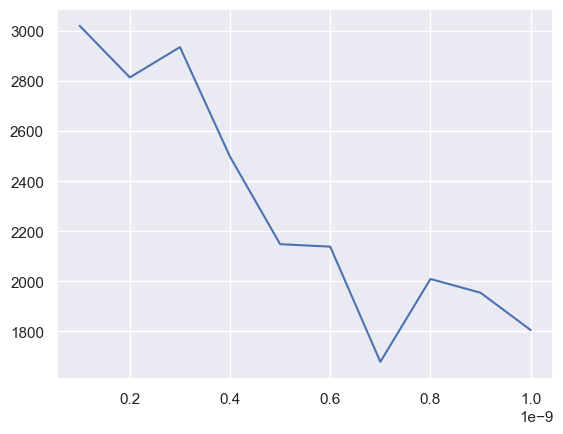

In [40]:
n_iter_df.mean(axis=0).plot()

<Axes: >

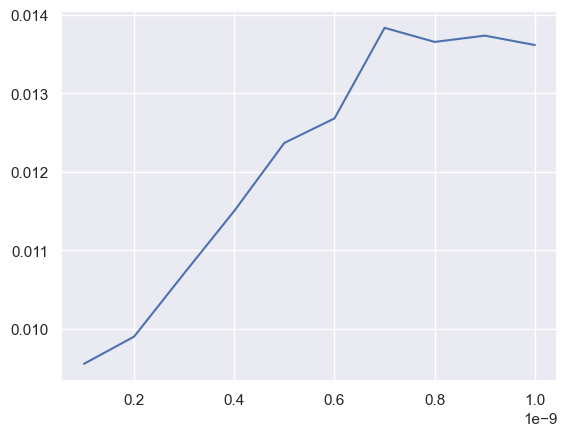

In [41]:
loss_nmf_df.mean(axis=0).plot()

<Axes: >

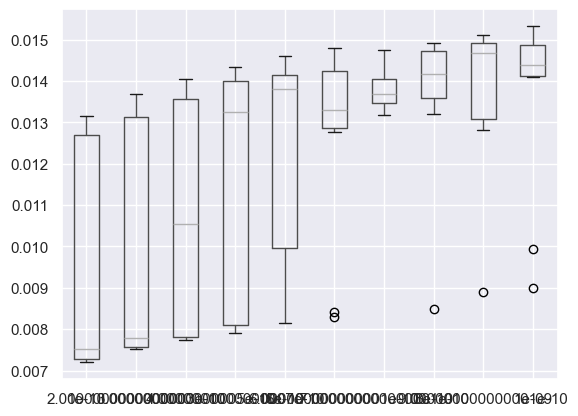

In [42]:
loss_nmf_df.boxplot()

In [43]:
loss_nmf_df.median(axis=0)

1.000000e-10    0.007508
2.000000e-10    0.007782
3.000000e-10    0.010546
4.000000e-10    0.013251
5.000000e-10    0.013802
6.000000e-10    0.013300
7.000000e-10    0.013689
8.000000e-10    0.014181
9.000000e-10    0.014675
1.000000e-09    0.014399
dtype: float64

In [44]:
loss_nmf_df

,1.000000e-10,2.000000e-10,3.000000e-10,4.000000e-10,5.000000e-10,6.000000e-10,7.000000e-10,8.000000e-10,9.000000e-10,1.000000e-09
0,0.012948,0.007901,0.013023,0.014347,0.014093,0.014809,0.014754,0.008476,0.014922,0.014137
1,0.012692,0.007601,0.007741,0.008184,0.008152,0.014111,0.013842,0.014155,0.012806,0.015245
2,0.013147,0.013275,0.007760,0.007915,0.013580,0.013447,0.013170,0.014207,0.014668,0.014108
3,0.007259,0.013693,0.007772,0.008076,0.013259,0.008404,0.014732,0.013801,0.014682,0.015331
4,0.007206,0.013568,0.013422,0.014065,0.014165,0.014399,0.013429,0.013523,0.012956,0.008990
5,0.007228,0.007663,0.013758,0.013105,0.008871,0.012779,0.013572,0.014750,0.014894,0.014433
6,0.007533,0.007526,0.014051,0.014208,0.014599,0.008304,0.013345,0.014931,0.013415,0.014678
7,0.012701,0.007544,0.007877,0.013825,0.014024,0.013137,0.013777,0.014853,0.015107,0.014366
8,0.007483,0.007542,0.008068,0.007916,0.014551,0.013154,0.013601,0.014652,0.008903,0.014939
9,0.007364,0.012713,0.013616,0.013397,0.008402,0.014273,0.014128,0.013210,0.015005,0.009935


<Axes: >

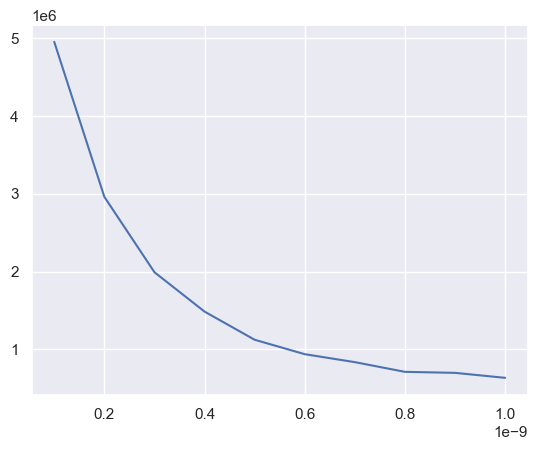

In [45]:
loss_constraint_df.mean(axis=0).plot()

Text(0.5, 0, 'alpha')

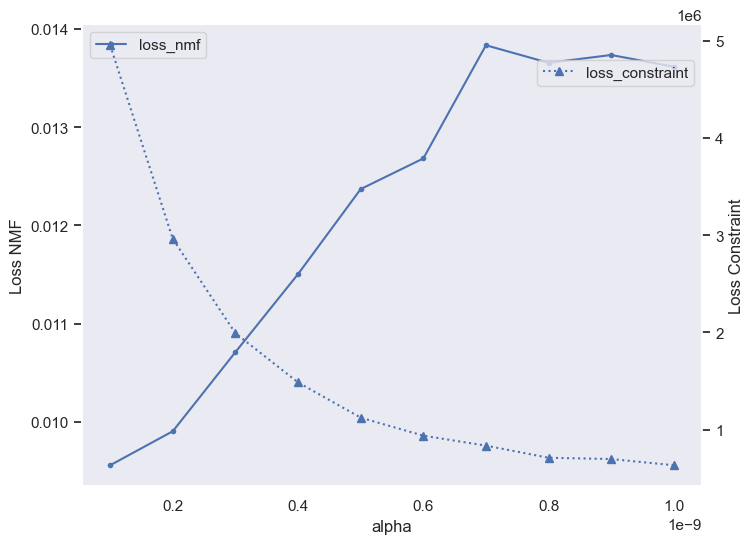

In [46]:
plt.figure(figsize=(8, 6))
ax1 = plt.gca()
loss_nmf_df.mean(axis=0).plot(ax=ax1, label='loss_nmf', marker='.')
ax1.grid(None)
ax1.legend()
ax1.set_ylabel('Loss NMF')

ax2 = ax1.twinx()
loss_constraint_df.mean(axis=0).plot(ax=ax2, label='loss_constraint', marker='^', linestyle='dotted')
ax2.grid(None)
ax2.legend(loc='upper right', bbox_to_anchor=(1,0.94))
ax2.set_ylabel('Loss Constraint')
ax1.set_xlabel('alpha')
# plt.xlim((0, 1e-8))

In [47]:
loss_nmf = loss_nmf_df.mean(axis=0).values
loss_constraint = loss_constraint_df.mean(axis=0).values

# Create the hover text with indices
hover_text_nmf = [f"Index: {i}<br>Alpha: {alpha:.1e}<br>Loss NMF: {loss}" for i, (alpha, loss) in enumerate(zip(alphas, loss_nmf))]
hover_text_constraint = [f"Index: {i}<br>Alpha: {alpha:.1e}<br>Loss Constraint: {loss}" for i, (alpha, loss) in enumerate(zip(alphas, loss_constraint))]

# Create traces
trace1 = go.Scatter(
    x=alphas,
    y=loss_nmf,
    mode='lines+markers',
    name='loss_nmf',
    marker=dict(symbol='circle'),
    line=dict(shape='linear'),
    hovertemplate=hover_text_nmf
)

trace2 = go.Scatter(
    x=alphas,
    y=loss_constraint,
    mode='lines+markers',
    name='loss_constraint',
    marker=dict(symbol='triangle-up'),
    line=dict(shape='linear', dash='dot'),
    yaxis='y2',
    hovertemplate=hover_text_constraint
)

# Create layout
layout = go.Layout(
    title='Loss vs Alpha',
    xaxis=dict(
        title='Alpha',
        type='log',  # Use logarithmic scale for x-axis
        # range=[-8, -5],  # Adjust range for log scale
        showgrid=False
    ),
    yaxis=dict(
        title='Loss NMF',
    ),
    yaxis2=dict(
        title='Loss Constraint',
        overlaying='y',
        side='right'
    ),
    width=1000,
    height=400,
    legend=dict(x=1, y=0.94)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# pio.write_html(fig, file='plot.html', auto_open=True)

# Show plot
fig.show()

In [54]:
tol = 1e-5
max_iter = 10000
verbose = 0
alpha = 3e-10

model = PenNMF(
    n_components=n_components,
    alpha=alpha,
    tol=tol,
    max_iter=max_iter,
    verbose=0
)

S_init = normalize_curves(np.ones((n_components, p)))
# C_init = initialize_C_gaussian_prior(C_init_mean)
C_init = initialize_W(X_train, n_components)

C = model.fit_transform(X_train.values, C_init.values, S_init, Y_train.values, A, B.values)

Total loss:  0.008412797970677913

Loss NMF:  0.007830435203071341
Loss constraint:  1941209.2253552368


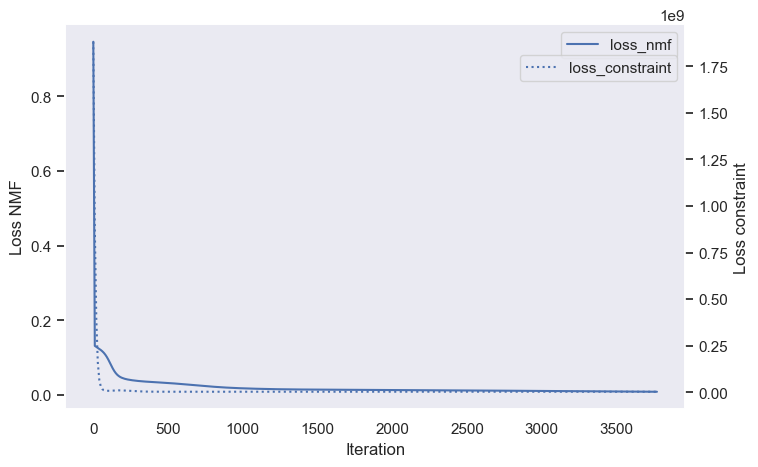

In [55]:
n_iter = model.n_iter_
losses_nmf = model.losses_nmf_
losses_constraint = model.losses_constraint_
plt.figure(figsize=(8, 5))
ax1 = plt.gca()
ax1.plot(np.arange(0, n_iter + 1, 10), losses_nmf, label='loss_nmf')
ax1.grid(None)
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(np.arange(0, n_iter + 1, 10), losses_constraint, linestyle='dotted', label='loss_constraint')
ax2.grid(None)
ax2.legend(loc='upper right', bbox_to_anchor=(1,0.94))

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss NMF')
ax2.set_ylabel('Loss constraint')

print("Total loss: ", losses_nmf[-1] + alpha * losses_constraint[-1])
print("\nLoss NMF: ", losses_nmf[-1])
print("Loss constraint: ", losses_constraint[-1])

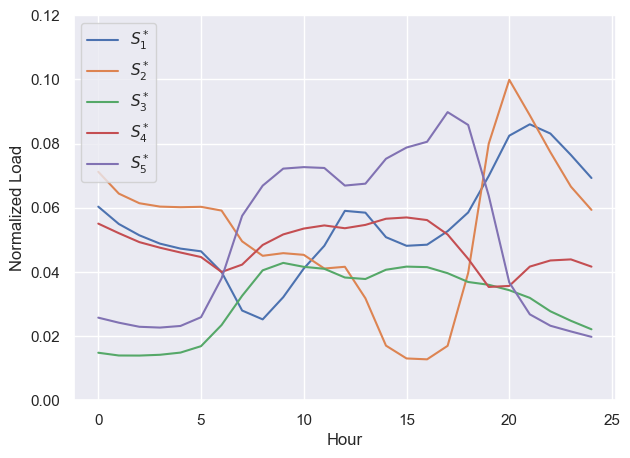

In [56]:
plot_components(model.components_, labels=[f'$S_{i+1}^*$' for i in range(n_components)], marker=None, linewidth=1.5, figsize=(7, 5))
ylim = plt.ylim((0, 0.12))

## Compare with NMF

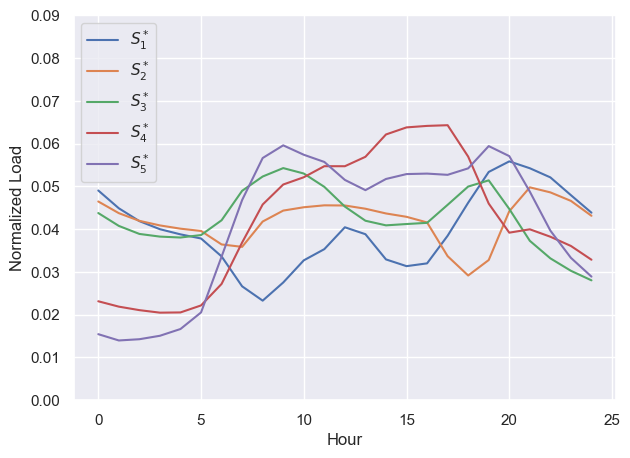

In [30]:
nmf = NMF(
        n_components=n_components,
        solver='mu',
        tol=tol,
        init='custom',
        max_iter=max_iter,
        verbose=verbose
)

C = nmf.fit_transform(
            X_train.values,
            W=C_init.values.copy(order='C'),
            H=S_init
        )

plot_components(nmf.components_, labels=[f'$S_{i+1}^*$' for i in range(n_components)], marker=None, linewidth=1.5, figsize=(7, 5))
ylim = plt.ylim((0, 0.09))

<Axes: >

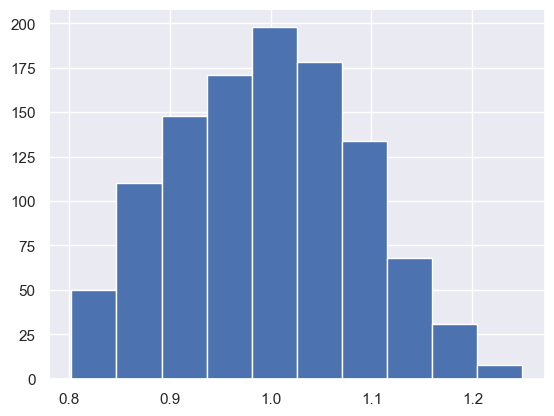

In [113]:
concentrations = pd.DataFrame(C, index=X_train.index)
concentrations.sum(axis=1).hist()

<HR>

# Tests